In [ ]:
import os

from datetime import date, datetime, timedelta

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from entsoe import EntsoePandasClient
from openmeteo_requests import Client as OpenMeteoClient

In [ ]:
TODAY = datetime.now().date().isoformat()
TOMORROW = (datetime.now() + timedelta(days=1)).date().isoformat()
TODAY, TOMORROW
DAYAFTER = (datetime.now() + timedelta(days=2)).date().isoformat()
DAYAFTER

'2024-08-04'

# Loading data

## Target

In [ ]:
prices = pd.read_parquet("data/entsoe/prices.parquet")
prices

,timestamp,day_ahead_price
0,2022-12-31 23:00:00+00:00,-4.39
1,2023-01-01 00:00:00+00:00,-1.75
2,2023-01-01 01:00:00+00:00,-1.46
3,2023-01-01 02:00:00+00:00,-5.27
4,2023-01-01 03:00:00+00:00,-4.41
...,...,...
13914,2024-08-02 17:00:00+00:00,104.27
13915,2024-08-02 18:00:00+00:00,117.59
13916,2024-08-02 19:00:00+00:00,112.77
13917,2024-08-02 20:00:00+00:00,107.90


## Exogenous Features

In [ ]:
elia_grid_load = pd.read_parquet("data/elia/ods001.parquet").rename(columns={"datetime": "timestamp"})
elia_grid_load['timestamp'] = elia_grid_load['timestamp'].dt.tz_localize('UTC')
elia_grid_load

,timestamp,resolutioncode,totalload,mostrecentforecast,mostrecentconfidence10,mostrecentconfidence90,dayaheadforecast,dayaheadconfidence10,dayaheadconfidence90,weekaheadforecast
0,2024-08-03 21:45:00+00:00,PT15M,NaN,7541.24,7182.15,7900.33,7541.24,7182.15,7900.33,7581.41
1,2024-08-03 21:30:00+00:00,PT15M,NaN,7653.84,7289.38,8018.29,7653.84,7289.38,8018.29,7709.15
2,2024-08-03 21:15:00+00:00,PT15M,NaN,7688.82,7322.70,8054.94,7688.82,7322.70,8054.94,7725.42
3,2024-08-03 21:00:00+00:00,PT15M,NaN,7807.84,7436.05,8179.62,7807.84,7436.05,8179.62,7826.13
4,2024-08-03 20:45:00+00:00,PT15M,NaN,7847.90,7485.48,8210.32,7847.90,7485.48,8210.32,7893.93
...,...,...,...,...,...,...,...,...,...,...
55767,2023-01-01 00:00:00+00:00,PT15M,7223.97,7381.91,7032.70,7731.12,7790.96,7480.15,8101.77,7771.15
55768,2022-12-31 23:45:00+00:00,PT15M,7246.50,7497.18,6904.79,8089.58,7978.78,7385.96,8571.61,8059.79
55769,2022-12-31 23:30:00+00:00,PT15M,7299.98,7653.99,7049.20,8258.77,8145.67,7540.44,8750.89,8202.97
55770,2022-12-31 23:15:00+00:00,PT15M,7419.53,7724.08,7113.75,8334.40,8220.27,7609.50,8831.04,8277.49


In [ ]:
elia_wind_generation = pd.read_parquet("data/elia/ods031.parquet").rename(columns={"datetime": "timestamp"})
elia_wind_generation['timestamp'] = elia_wind_generation['timestamp'].dt.tz_localize('UTC')
elia_wind_generation

,timestamp,resolutioncode,offshoreonshore,region,gridconnectiontype,measured,mostrecentforecast,mostrecentconfidence10,mostrecentconfidence90,dayahead11hforecast,...,dayahead11hconfidence90,dayaheadforecast,dayaheadconfidence10,dayaheadconfidence90,weekaheadforecast,weekaheadconfidence10,weekaheadconfidence90,monitoredcapacity,loadfactor,decrementalbidid
0,2024-08-01 21:45:00+00:00,PT15M,Onshore,Wallonia,Dso,7.71,8.80,0.40,52.00,24.00,...,103.40,34.90,4.70,106.60,21.10,4.70,514.70,1146.34,0.01,''
1,2024-08-01 21:45:00+00:00,PT15M,Onshore,Wallonia,Elia,0.00,0.50,0.00,10.20,2.30,...,17.30,3.30,0.00,17.30,1.70,0.00,111.40,211.10,0.00,''
2,2024-08-01 21:45:00+00:00,PT15M,Onshore,Flanders,Dso,13.75,16.60,3.80,61.20,79.90,...,186.00,77.50,33.60,155.00,35.50,17.50,557.60,1488.59,0.01,''
3,2024-08-01 21:45:00+00:00,PT15M,Onshore,Flanders,Elia,2.54,4.40,0.20,16.30,23.90,...,62.30,22.40,5.00,50.90,7.70,5.50,172.30,331.05,0.01,''
4,2024-08-01 21:45:00+00:00,PT15M,Offshore,Federal,Elia,1.08,35.20,0.30,174.00,70.20,...,379.40,61.70,3.40,351.80,15.60,11.60,2083.40,2262.10,0.00,''
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
277895,2022-12-31 23:00:00+00:00,PT15M,Onshore,Flanders,Elia,286.19,265.70,240.70,271.80,262.80,...,278.60,262.60,205.60,273.90,250.60,221.50,268.50,373.25,0.77,''
277896,2022-12-31 23:00:00+00:00,PT15M,Onshore,Wallonia,Dso,812.74,810.20,737.90,833.10,814.70,...,871.90,815.90,734.10,867.60,822.00,720.50,882.00,1071.88,0.76,''
277897,2022-12-31 23:00:00+00:00,PT15M,Onshore,Wallonia,Elia,103.77,88.00,70.20,89.20,86.80,...,112.60,88.50,74.90,109.30,83.30,46.90,107.80,158.60,0.65,''
277898,2022-12-31 23:00:00+00:00,PT15M,Onshore,Flanders,Dso,1010.36,974.20,883.50,982.00,958.80,...,979.30,960.50,823.50,988.00,1000.40,939.10,1031.20,1353.86,0.75,''


In [ ]:
elia_pv_generation = pd.read_parquet("data/elia/ods032.parquet").rename(columns={"datetime": "timestamp"})
elia_pv_generation['timestamp'] = elia_pv_generation['timestamp'].dt.tz_localize('UTC')
elia_pv_generation

,timestamp,resolutioncode,region,measured,mostrecentforecast,mostrecentconfidence10,mostrecentconfidence90,dayahead11hforecast,dayahead11hconfidence10,dayahead11hconfidence90,dayaheadforecast,dayaheadconfidence10,dayaheadconfidence90,weekaheadforecast,weekaheadconfidence10,weekaheadconfidence90,monitoredcapacity,loadfactor
0,2024-08-01 21:45:00+00:00,PT15M,Belgium,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10200.291,NaN
1,2024-08-01 21:30:00+00:00,PT15M,Belgium,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10200.291,0.0
2,2024-08-01 21:15:00+00:00,PT15M,Belgium,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10200.291,0.0
3,2024-08-01 21:00:00+00:00,PT15M,Belgium,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10200.291,0.0
4,2024-08-01 20:45:00+00:00,PT15M,Belgium,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10200.291,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55575,2023-01-01 00:00:00+00:00,PT15M,Belgium,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6474.961,0.0
55576,2022-12-31 23:45:00+00:00,PT15M,Belgium,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6474.961,0.0
55577,2022-12-31 23:30:00+00:00,PT15M,Belgium,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6474.961,0.0
55578,2022-12-31 23:15:00+00:00,PT15M,Belgium,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6474.961,0.0


In [ ]:
historical_weather = pd.read_parquet("data/openmeteo/historical_weather.parquet")
historical_weather

,timestamp,relative_humidity_2m,temperature_2m
0,2023-01-01 00:00:00+00:00,50.773548,14.708
1,2023-01-01 01:00:00+00:00,54.164318,14.408
2,2023-01-01 02:00:00+00:00,55.355537,14.608
3,2023-01-01 03:00:00+00:00,64.645088,13.858
4,2023-01-01 04:00:00+00:00,67.762497,13.658
...,...,...,...
13915,2024-08-02 19:00:00+00:00,NaN,NaN
13916,2024-08-02 20:00:00+00:00,NaN,NaN
13917,2024-08-02 21:00:00+00:00,NaN,NaN
13918,2024-08-02 22:00:00+00:00,NaN,NaN


In [ ]:
weather_forecast = pd.read_parquet("data/openmeteo/weather_forecast.parquet")
weather_forecast

,timestamp,relative_humidity_2m,temperature_2m
0,2024-08-02 00:00:00+00:00,84.0,21.395500
1,2024-08-02 01:00:00+00:00,88.0,20.295500
2,2024-08-02 02:00:00+00:00,87.0,19.795500
3,2024-08-02 03:00:00+00:00,89.0,20.095499
4,2024-08-02 04:00:00+00:00,93.0,19.045500
...,...,...,...
163,2024-08-08 19:00:00+00:00,62.0,23.600000
164,2024-08-08 20:00:00+00:00,69.0,22.000000
165,2024-08-08 21:00:00+00:00,75.0,20.400000
166,2024-08-08 22:00:00+00:00,81.0,18.700001


# Modeling

In [ ]:
from enfobench import Dataset
from enfobench.evaluation import cross_validate, evaluate_metrics
from enfobench.evaluation.utils import create_forecast_index

In [ ]:
target = prices.set_index("timestamp").rename(columns={"day_ahead_price": "y"})
target.index = target.index.tz_convert("Europe/Brussels").tz_localize(None)
target

,y
timestamp,
2023-01-01 00:00:00,-4.39
2023-01-01 01:00:00,-1.75
2023-01-01 02:00:00,-1.46
2023-01-01 03:00:00,-5.27
2023-01-01 04:00:00,-4.41
...,...
2024-08-02 19:00:00,104.27
2024-08-02 20:00:00,117.59
2024-08-02 21:00:00,112.77


In [ ]:
past_covariates = elia_grid_load.set_index("timestamp").add_prefix("load_")
past_covariates.index = past_covariates.index.tz_convert("Europe/Brussels").tz_localize(None)
past_covariates

,load_resolutioncode,load_totalload,load_mostrecentforecast,load_mostrecentconfidence10,load_mostrecentconfidence90,load_dayaheadforecast,load_dayaheadconfidence10,load_dayaheadconfidence90,load_weekaheadforecast
timestamp,,,,,,,,,
2024-08-03 23:45:00,PT15M,NaN,7541.24,7182.15,7900.33,7541.24,7182.15,7900.33,7581.41
2024-08-03 23:30:00,PT15M,NaN,7653.84,7289.38,8018.29,7653.84,7289.38,8018.29,7709.15
2024-08-03 23:15:00,PT15M,NaN,7688.82,7322.70,8054.94,7688.82,7322.70,8054.94,7725.42
2024-08-03 23:00:00,PT15M,NaN,7807.84,7436.05,8179.62,7807.84,7436.05,8179.62,7826.13
2024-08-03 22:45:00,PT15M,NaN,7847.90,7485.48,8210.32,7847.90,7485.48,8210.32,7893.93
...,...,...,...,...,...,...,...,...,...
2023-01-01 01:00:00,PT15M,7223.97,7381.91,7032.70,7731.12,7790.96,7480.15,8101.77,7771.15
2023-01-01 00:45:00,PT15M,7246.50,7497.18,6904.79,8089.58,7978.78,7385.96,8571.61,8059.79
2023-01-01 00:30:00,PT15M,7299.98,7653.99,7049.20,8258.77,8145.67,7540.44,8750.89,8202.97


In [ ]:
future_covariates = weather_forecast.set_index("timestamp").add_prefix("wind_")
future_covariates.index = future_covariates.index.tz_convert("Europe/Brussels").tz_localize(None)
future_covariates

,wind_relative_humidity_2m,wind_temperature_2m
timestamp,,
2024-08-02 02:00:00,84.0,21.395500
2024-08-02 03:00:00,88.0,20.295500
2024-08-02 04:00:00,87.0,19.795500
2024-08-02 05:00:00,89.0,20.095499
2024-08-02 06:00:00,93.0,19.045500
...,...,...
2024-08-08 21:00:00,62.0,23.600000
2024-08-08 22:00:00,69.0,22.000000
2024-08-08 23:00:00,75.0,20.400000


In [ ]:
print(target.index.duplicated().sum())
print(past_covariates.index.duplicated().sum())
print(future_covariates.index.duplicated().sum())



1
4
0


In [ ]:
target = target[~target.index.duplicated()]
past_covariates = past_covariates[~past_covariates.index.duplicated()]


In [ ]:
dataset = Dataset(
    target=target,
    past_covariates=past_covariates,
    metadata={
        "freq": "1h",
    }
)

/root/venv/lib/python3.11/site-packages/enfobench/core/dataset.py:51: UserWarning: Frequency cannot be inferred from target's index, resampling target.
  self._target = self._check_target(target.copy())


In [ ]:
class Forecaster:

    def __init__(self):
        # Create any attributes at creation
        pass

    def forecast(
        self, 
        horizon: int,
        history: pd.DataFrame,
        past_covariates: pd.DataFrame,
        future_covariates: pd.DataFrame | None,
        metadata: dict,
        **kwargs
    ) -> pd.DataFrame:
        """Prediction method of Forecaster model.
        

        """
        # Handle missing values
        y = history.y.fillna(history.y.mean())

        # Make forecast
        model = ARIMA(y, order=(18, 1, 0))  # Example order, should be tuned for your data
        model_fit = model.fit()
        forecast = model_fit.forecast(steps=horizon)
        index = self.create_forecast_index(history=history, horizon=horizon)
        
        ### index = create_forecast_index(history=history, horizon=horizon)
        ### pred: pd.Series = history.iloc[-25:].y

        # Postprocess forecast to match the expected format (yhat column as prediction with DateTimeIndex)
        y_pred = pd.DataFrame(
            index=index,
            data={
                'yhat': forecast
            }
        ).fillna(y.mean())
        return y_pred

    def create_forecast_index(self, history: pd.DataFrame, horizon: int) -> pd.DatetimeIndex:
        """
        Create a forecast index based on the historical data and forecast horizon.

        Parameters:
        history (pd.DataFrame): Historical data with a datetime index.
        horizon (int): The number of periods to forecast into the future.

        Returns:
        pd.DatetimeIndex: Datetime index for the forecast period.
        """
        last_date = history.index[-1]
        forecast_index = pd.date_range(start=last_date + pd.Timedelta(hours=1), periods=horizon, freq='H')
        return forecast_index

model = Forecaster()

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import TimeSeriesSplit

In [ ]:
1
    end_date=pd.Timestamp("2024-03-01"),
    horizon=pd.Timedelta("25 hours"),
    step=pd.Timedelta("1 day"),
)
cutoff_dates = list(crossval_df.cutoff_date.unique())
crossval_df

100%|██████████| 28/28 [23:34<00:00, 50.52s/it]


,cutoff_date,timestamp,yhat,y
0,2024-02-01,2024-02-01 00:00:00,37.269465,49.53
1,2024-02-01,2024-02-01 01:00:00,37.952299,44.19
2,2024-02-01,2024-02-01 02:00:00,41.038504,44.47
3,2024-02-01,2024-02-01 03:00:00,51.622374,45.15
4,2024-02-01,2024-02-01 04:00:00,61.787512,49.02
...,...,...,...,...
695,2024-02-28,2024-02-28 20:00:00,77.181373,66.01
696,2024-02-28,2024-02-28 21:00:00,73.452297,63.14
697,2024-02-28,2024-02-28 22:00:00,69.579076,64.31
698,2024-02-28,2024-02-28 23:00:00,66.068515,55.37


In [ ]:
cutoff_date = '2024-02-02 00:00:00'

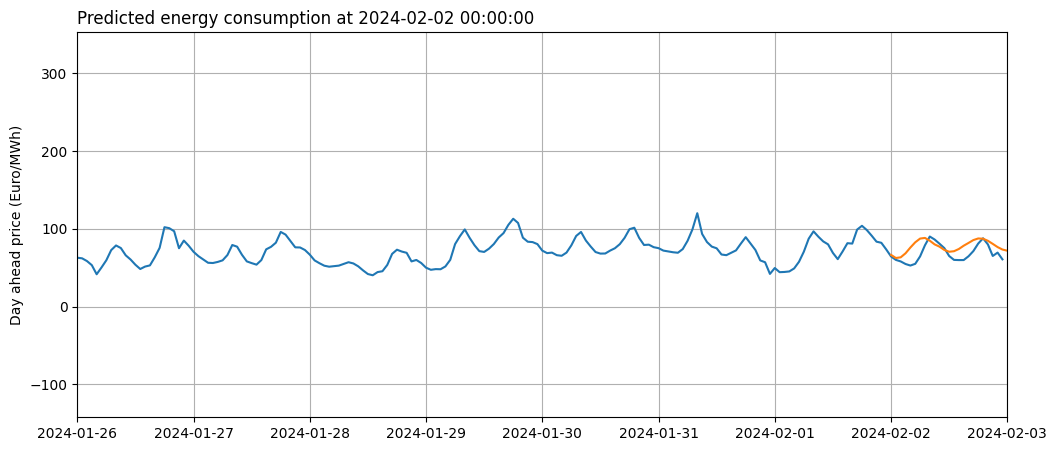

In [ ]:
fig, ax = plt.subplots(figsize=(12, 5))
forecast = (
    crossval_df.loc[crossval_df.cutoff_date == pd.Timestamp(cutoff_date)].set_index("timestamp")
)
history = dataset.get_history(forecast.index.max())

ax.plot(history.index, history.y)
ax.plot(forecast.index, forecast.yhat)
ax.set_xlim(forecast.index.min() - pd.Timedelta('7D'), forecast.index.max())
ax.set_ylabel("Day ahead price (Euro/MWh)")
ax.grid(True)
ax.set_title(f"Predicted energy consumption at {cutoff_date}", fontsize="large", loc="left")
plt.show()

In [ ]:
from enfobench.evaluation.metrics import (
    mean_bias_error,
    mean_absolute_error,
    mean_squared_error,
    root_mean_squared_error,
)

# Simply pass in the cross validation results and the metrics you want to evaluate.
metrics = evaluate_metrics(
    crossval_df,
    metrics={
        "mean_bias_error": mean_bias_error,
        "mean_absolute_error": mean_absolute_error,
        "mean_squared_error": mean_squared_error,
        "root_mean_squared_error": root_mean_squared_error,
    },
)
metrics

,mean_bias_error,mean_absolute_error,mean_squared_error,root_mean_squared_error,weight
0,-0.078722,11.84631,273.709722,16.544175,1.0


# Prediction

## Selecting most recent data

In [ ]:
fill_missing_dates = True
frequency = '1H'

In [ ]:
last_available_date = dataset._last_available_target_date

# Use this date as the cutoff date
cutoff_date_str = "2024-08-02T23:00:00"
cutoff_date = pd.Timestamp(cutoff_date_str)
end_date_str = "2024-08-03T24:00:00"
end_date = pd.Timestamp(cutoff_date_str)


# Use this date as the cutoff date
history = dataset.get_history(cutoff_date)
past_covariates = dataset.get_past_covariates(cutoff_date)
future_covariates = None   #dataset.get_future_covariates(end_date)

NameError: name 'dataset' is not defined

## Making prediction

In [ ]:
forecast_df = model.forecast(
    horizon=25,
    history=history,
    past_covariates=past_covariates,
    future_covariates=future_covariates,
    metadata=dataset.metadata
)
forecast_df.index = forecast_df.index.tz_localize("Europe/Brussels")
forecast_df = forecast_df.rename_axis("timestamp").reset_index() # Formatting timestamp column
forecast_df = forecast_df.drop(forecast_df.index[0]).reset_index(drop=True)

forecast_df

,timestamp,yhat
0,2024-08-01 00:00:00+02:00,79.557554
1,2024-08-01 01:00:00+02:00,72.738627
2,2024-08-01 02:00:00+02:00,67.783441
3,2024-08-01 03:00:00+02:00,70.729695
4,2024-08-01 04:00:00+02:00,77.143266
5,2024-08-01 05:00:00+02:00,86.320866
6,2024-08-01 06:00:00+02:00,93.135398
7,2024-08-01 07:00:00+02:00,96.287560
8,2024-08-01 08:00:00+02:00,92.470544
9,2024-08-01 09:00:00+02:00,83.492767


In [ ]:
import inspect
_dntk.DeepnoteChart(forecast_df, """{"layer":[{"layer":[{"mark":{"clip":true,"type":"trail","color":"#2266D3","tooltip":true},"encoding":{"x":{"axis":{"grid":false},"sort":"ascending","type":"temporal","field":"timestamp","scale":{"type":"linear","zero":false}},"y":{"axis":{"grid":false},"sort":null,"type":"quantitative","field":"yhat","scale":{"type":"linear","zero":false},"format":{"type":"default","decimals":null},"formatType":"numberFormatFromNumberType"}}}]}],"title":"","config":{"legend":{}},"$schema":"https://vega.github.io/schema/vega-lite/v5.json","encoding":{},"usermeta":{"tooltipDefaultMode":true}}""", **({'attach_selection': True} if 'attach_selection' in inspect.signature(_dntk.DeepnoteChart).parameters else {}), **({'filters': '[]'} if 'filters' in inspect.signature(_dntk.DeepnoteChart).parameters else {}))

## Saving and validating forecast schema

In [ ]:
# DO NOT CHANGE THIS CELL
# This cell check the conformity of your prediction DataFrame and saves the prediction in the forecasts fold
import pandera as pa
from pandera import Column, DataFrameSchema, Check, Index, check_input

forecast_schema = DataFrameSchema(
    {
        "timestamp": Column(
            pa.engines.pandas_engine.DateTime(
                to_datetime_kwargs={"format": "%Y-%m-%dT%H:%M:%S"}, tz="Europe/Brussels", unit="ns"
            ),
            required=True,
            nullable=False,
        ),
        "yhat": Column(float, required=True, nullable=False),
    },
    strict=True,
    coerce=True,
)

@check_input(forecast_schema)
def save_forecast(forecast_df: pd.DataFrame, path: str) -> None:
    assert len(forecast_df) == 24
    forecast_df.to_csv(path, index=False)

Use the following cell to save your predictions. You can version or name the forecasts however you would like.

In [ ]:
TEAM_NAME = "energy-engineers"
VERSION = "1.3.0"
save_forecast(forecast_df, f"forecasts/forecast_{TEAM_NAME}_{TOMORROW}_v{VERSION}.csv")